## Notebook Land use Hexagons

In this notebook, we continue processing the land use data by calculation the land use percentage for each land use type and hexagon in all 3 spatial resolutions.

## Imports 

In [1]:
import geopandas as gpd
import pandas as pd
import h3 
import shapely
import geojson

In [2]:
import sys, os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

from modules.config import *

In [4]:
#read land use polygons
land_use_flexzone = pd.read_pickle("../00_data/processed/land_use_flexzone.pkl")
land_use_flexzone

,geometry,class_2018
0,"POLYGON ((51.25573 12.37944, 51.25572 12.37906...",Discontinuous dense urban fabric (S.L. : 50% -...
1,"POLYGON ((51.32675 12.28788, 51.32606 12.28668...",Discontinuous dense urban fabric (S.L. : 50% -...
2,"POLYGON ((51.27010 12.36293, 51.26951 12.36298...",Discontinuous dense urban fabric (S.L. : 50% -...
3,"POLYGON ((51.30811 12.43117, 51.30813 12.43117...","Industrial, commercial, public, military and p..."
4,"POLYGON ((51.33568 12.38648, 51.33591 12.38532...",Continuous urban fabric (S.L. : > 80%)
...,...,...
7310,"POLYGON ((51.39093 12.31474, 51.39170 12.31463...",Sports and leisure facilities
7311,"POLYGON ((51.39186 12.31176, 51.39179 12.31350...",Sports and leisure facilities
7312,"POLYGON ((51.38517 12.35545, 51.38508 12.35522...",Sports and leisure facilities
7313,"POLYGON ((51.36356 12.40752, 51.36355 12.40752...",Sports and leisure facilities


In [7]:
#read in relevant hexagon ids
trips_grouped = pd.read_parquet(TRIPS_GROUPED_SPATIO_TEMPORAL_PATH)
trips_grouped.reset_index(inplace=True)
trips_grouped

,index,datetime_start_floored,start_hex_id,end_hex_id,demand,h3_res,time_interval_length
0,0,2019-01-20,871f1a164ffffff,871f1a164ffffff,1,7,1
1,1,2019-01-20,871f1a164ffffff,871f1a8c8ffffff,2,7,1
2,2,2019-01-20,871f1a164ffffff,871f1a8cbffffff,1,7,1
3,3,2019-01-20,871f1a164ffffff,871f1a8d9ffffff,3,7,1
4,4,2019-01-20,871f1a165ffffff,871f1ab96ffffff,1,7,1
...,...,...,...,...,...,...,...
4253142,494293,2019-12-30,891f1abb267ffff,891f1abb27bffff,2,9,24
4253143,494294,2019-12-30,891f1abb27bffff,891f1abb243ffff,1,9,24
4253144,494295,2019-12-30,891f1abb63bffff,891f1a8cda7ffff,1,9,24
4253145,494296,2019-12-30,891f1abb63bffff,891f1ab968bffff,1,9,24


## Build Dataframe containing all relevant hexagons

In [9]:
#extract hexagons ids from trip dataframe and remove duplicates
hexagons = trips_grouped["start_hex_id"].append(trips_grouped["end_hex_id"], ignore_index=True)
hexagons = hexagons.drop_duplicates()
hexagons = pd.DataFrame(hexagons,columns=["hexagon_id"])
hexagons

C:\Users\annes\AppData\Local\Temp\ipykernel_19732\4058780210.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hexagons = trips_grouped["start_hex_id"].append(trips_grouped["end_hex_id"], ignore_index=True)


,hexagon_id
0,871f1a164ffffff
4,871f1a165ffffff
5,871f1a8caffffff
7,871f1a8cbffffff
11,871f1a8d9ffffff
...,...
6899396,891f1a8ce13ffff
6925274,891f1a8c3cfffff
6925636,891f1ab9203ffff
6940858,891f1a16e07ffff


In [10]:
from shapely.geometry import Polygon
from shapely.geometry import Point

#create polygon geometries from hexagon ids
hexagons['geometry'] = hexagons["hexagon_id"].apply(lambda x: h3.h3_to_geo_boundary(h=x, geo_json=True))
# turn to Point
hexagons['geometry'] = hexagons['geometry'].apply(lambda x: [Point(x,y) for [x,y] in x])
# turn to Polygon
hexagons['geometry'] = hexagons['geometry'].apply(lambda x: Polygon([[poly.x, poly.y] for poly in x]))
hexagons

,hexagon_id,geometry
0,871f1a164ffffff,POLYGON ((12.346786662435251 51.33085328309887...
4,871f1a165ffffff,POLYGON ((12.381389746246748 51.33327737685883...
5,871f1a8caffffff,"POLYGON ((12.327934342411194 51.3470752173761,..."
7,871f1a8cbffffff,POLYGON ((12.362542349855879 51.34950529781296...
11,871f1a8d9ffffff,POLYGON ((12.312190705376985 51.32841923946066...
...,...,...
6899396,891f1a8ce13ffff,POLYGON ((12.321657739148023 51.36167009441473...
6925274,891f1a8c3cfffff,"POLYGON ((12.27985945741952 51.3562130592888, ..."
6925636,891f1ab9203ffff,POLYGON ((12.431271639780801 51.33173920919087...
6940858,891f1a16e07ffff,POLYGON ((12.439268644954103 51.29718466360897...


<AxesSubplot:>

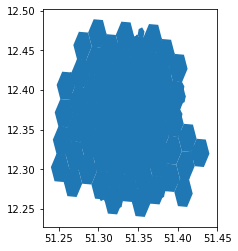

In [11]:
#switch coordinates and plot hexagons
hexagons=  gpd.GeoDataFrame(hexagons)
hexagons.geometry = hexagons.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

## Transform land use categories to numeric values

In [12]:
#rename column
land_use_flexzone.rename(columns={"class_2018":"land_use"}, inplace=True)
land_use_flexzone

,geometry,land_use
0,"POLYGON ((51.25573 12.37944, 51.25572 12.37906...",Discontinuous dense urban fabric (S.L. : 50% -...
1,"POLYGON ((51.32675 12.28788, 51.32606 12.28668...",Discontinuous dense urban fabric (S.L. : 50% -...
2,"POLYGON ((51.27010 12.36293, 51.26951 12.36298...",Discontinuous dense urban fabric (S.L. : 50% -...
3,"POLYGON ((51.30811 12.43117, 51.30813 12.43117...","Industrial, commercial, public, military and p..."
4,"POLYGON ((51.33568 12.38648, 51.33591 12.38532...",Continuous urban fabric (S.L. : > 80%)
...,...,...
7310,"POLYGON ((51.39093 12.31474, 51.39170 12.31463...",Sports and leisure facilities
7311,"POLYGON ((51.39186 12.31176, 51.39179 12.31350...",Sports and leisure facilities
7312,"POLYGON ((51.38517 12.35545, 51.38508 12.35522...",Sports and leisure facilities
7313,"POLYGON ((51.36356 12.40752, 51.36355 12.40752...",Sports and leisure facilities


In [14]:
#create dictionary for land use types
land_use_dict = {"Discontinuous dense urban fabric (S.L. : 50% -  80%)":1, 
                    "Industrial, commercial, public, military and private units":2,
                    "Continuous urban fabric (S.L. : > 80%)":3, 
                    "Sports and leisure facilities":4, 
                    "Green urban areas":5,
                    "Discontinuous medium density urban fabric (S.L. : 30% - 50%)":6,
                    "Arable land (annual crops)":7,
                    "Pastures":8,
                    "Land without current use":9,
                    "Forests":10,
                    "Water":11,
                    "Railways and associated land":12,
                    "Discontinuous low density urban fabric (S.L. : 10% - 30%)":13,
                    "Mineral extraction and dump sites":14,                                                    
                    "Isolated structures":15,                                                               
                    "Herbaceous vegetation associations (natural grassland, moors...)":16,                    
                    "Discontinuous very low density urban fabric (S.L. : < 10%)":17,                          
                    "Construction sites":18,                                                                   
                    "Fast transit roads and associated land":19,                                               
                    "Other roads and associated land":20,                                                       
                    "Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)":21,       
                    "Wetlands":22}

import json 

with open('../00_data/processed/land_use_dict.json', 'w') as fp:
    json.dump(land_use_dict, fp)

land_use_types = land_use_flexzone["land_use"].unique()
land_use_types

array(['Discontinuous dense urban fabric (S.L. : 50% -  80%)',
       'Industrial, commercial, public, military and private units',
       'Continuous urban fabric (S.L. : > 80%)',
       'Fast transit roads and associated land',
       'Other roads and associated land', 'Railways and associated land',
       'Land without current use', 'Green urban areas',
       'Sports and leisure facilities', 'Arable land (annual crops)',
       'Discontinuous very low density urban fabric (S.L. : < 10%)',
       'Discontinuous medium density urban fabric (S.L. : 30% - 50%)',
       'Pastures',
       'Discontinuous low density urban fabric (S.L. : 10% - 30%)',
       'Forests', 'Isolated structures', 'Water',
       'Open spaces with little or no vegetation (beaches, dunes, bare rocks, glaciers)',
       'Construction sites', 'Mineral extraction and dump sites',
       'Herbaceous vegetation associations (natural grassland, moors...)',
       'Wetlands'], dtype=object)

In [15]:
#replace categorical with numerical values for land use types
land_use_flexzone["land_use"] = land_use_flexzone["land_use"].map(land_use_dict)

In [16]:
#take a look at the frequency of land use types in the flexzone
land_use_flexzone["land_use"].value_counts()

1     1936
2     1336
3     1319
4      589
5      554
6      397
7      312
8      263
9      191
10      96
11      86
12      72
13      61
14      22
15      16
16      16
17      12
18      12
19      10
20       9
21       5
22       1
Name: land_use, dtype: int64

## Calculate land use types for each hexagon in percent

In [17]:
#match coordinate reference systems
hexagons = gpd.GeoDataFrame(hexagons, crs= "EPSG:4326")
land_use_flexzone = gpd.GeoDataFrame(land_use_flexzone, crs= "EPSG:4326")

hexagons 

C:\Users\annes\AppData\Local\Temp\ipykernel_19732\1752551418.py:2: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  hexagons = gpd.GeoDataFrame(hexagons, crs= "EPSG:4326")


,hexagon_id,geometry
0,871f1a164ffffff,"POLYGON ((51.33085 12.34679, 51.31923 12.34782..."
4,871f1a165ffffff,"POLYGON ((51.33328 12.38139, 51.32165 12.38242..."
5,871f1a8caffffff,"POLYGON ((51.34708 12.32793, 51.33545 12.32897..."
7,871f1a8cbffffff,"POLYGON ((51.34951 12.36254, 51.33788 12.36357..."
11,871f1a8d9ffffff,"POLYGON ((51.32842 12.31219, 51.31679 12.31323..."
...,...,...
6899396,891f1a8ce13ffff,"POLYGON ((51.36167 12.32166, 51.36001 12.32181..."
6925274,891f1a8c3cfffff,"POLYGON ((51.35621 12.27986, 51.35455 12.28001..."
6925636,891f1ab9203ffff,"POLYGON ((51.33174 12.43127, 51.33008 12.43142..."
6940858,891f1a16e07ffff,"POLYGON ((51.29718 12.43927, 51.29552 12.43941..."


In [25]:
#calulate hexagon size
hexagons["area"] = hexagons.geometry.area
hexagons["area"]

0          0.000607
4          0.000607
5          0.000607
7          0.000607
11         0.000607
             ...   
6899396    0.000012
6925274    0.000012
6925636    0.000012
6940858    0.000012
6949071    0.000012
Name: area, Length: 1689, dtype: float64

In [26]:
#map land use to hexagons
result_gdf = gpd.overlay(hexagons , land_use_flexzone , how='intersection')
result_gdf

,hexagon_id,area,land_use,geometry
0,871f1a164ffffff,0.000607,2,"POLYGON ((51.33036 12.37343, 51.33041 12.37282..."
1,881f1a164bfffff,0.000087,2,"POLYGON ((51.33036 12.37343, 51.33041 12.37282..."
2,891f1a164abffff,0.000012,2,"POLYGON ((51.33036 12.37343, 51.33041 12.37282..."
3,871f1a164ffffff,0.000607,20,"MULTIPOLYGON (((51.32886 12.34696, 51.32885 12..."
4,871f1a165ffffff,0.000607,20,"MULTIPOLYGON (((51.33271 12.38144, 51.33265 12..."
...,...,...,...,...
33247,871f1a168ffffff,0.000608,8,"POLYGON ((51.30349 12.46749, 51.30232 12.46733..."
33248,881f1a1689fffff,0.000087,8,"POLYGON ((51.30181 12.46758, 51.30187 12.46759..."
33249,891f1a1688bffff,0.000012,8,"POLYGON ((51.30214 12.46762, 51.30284 12.46768..."
33250,881f1abb69fffff,0.000087,12,"POLYGON ((51.40777 12.38424, 51.40706 12.38455..."


In [31]:
#calculate are the overlap for each existing pair of land use and hexagon
result_gdf["land_use_area"]= result_gdf.geometry.apply(lambda x: x.area)
result_gdf["overlap"] = result_gdf["land_use_area"] / result_gdf["area"]
result_gdf

,hexagon_id,area,land_use,geometry,Land_use_area,land_use_area,overlap
0,871f1a164ffffff,0.000607,2,"POLYGON ((51.33036 12.37343, 51.33041 12.37282...",4.069970e-07,4.069970e-07,0.000670
1,881f1a164bfffff,0.000087,2,"POLYGON ((51.33036 12.37343, 51.33041 12.37282...",4.069970e-07,4.069970e-07,0.004691
2,891f1a164abffff,0.000012,2,"POLYGON ((51.33036 12.37343, 51.33041 12.37282...",4.069970e-07,4.069970e-07,0.032839
3,871f1a164ffffff,0.000607,20,"MULTIPOLYGON (((51.32886 12.34696, 51.32885 12...",6.110645e-05,6.110645e-05,0.100627
4,871f1a165ffffff,0.000607,20,"MULTIPOLYGON (((51.33271 12.38144, 51.33265 12...",6.696478e-05,6.696478e-05,0.110251
...,...,...,...,...,...,...,...
33247,871f1a168ffffff,0.000608,8,"POLYGON ((51.30349 12.46749, 51.30232 12.46733...",1.300208e-06,1.300208e-06,0.002140
33248,881f1a1689fffff,0.000087,8,"POLYGON ((51.30181 12.46758, 51.30187 12.46759...",8.051564e-07,8.051564e-07,0.009276
33249,891f1a1688bffff,0.000012,8,"POLYGON ((51.30214 12.46762, 51.30284 12.46768...",5.885843e-07,5.885843e-07,0.047465
33250,881f1abb69fffff,0.000087,12,"POLYGON ((51.40777 12.38424, 51.40706 12.38455...",1.893575e-07,1.893575e-07,0.002182


In [32]:
#checking closely the sum of percentages matches 100%
percentage_check =result_gdf.groupby("hexagon_id")["overlap"].sum()
percentage_check

hexagon_id
871f1a140ffffff    0.626564
871f1a144ffffff    1.000000
871f1a145ffffff    0.999471
871f1a146ffffff    0.672314
871f1a160ffffff    1.000000
                     ...   
891f1abb6afffff    1.000000
891f1abb6b3ffff    1.000000
891f1abb6c3ffff    1.000000
891f1abb6c7ffff    1.000000
891f1abb6dbffff    1.000000
Name: overlap, Length: 1689, dtype: float64

In [33]:
#Some statistics regarding the deviation of the sum of percentages of land use types from 100%
print("Maximum: " ,percentage_check.max())
print("Minimum: " ,percentage_check.min())
print("Mean: " ,percentage_check.mean())
print("Median: " ,percentage_check.median())
print("Standard Deviation: " ,percentage_check.std())


Maximum:  1.0000000000016567
Minimum:  0.042527446646988376
Mean:  0.9876343809776971
Median:  0.9999999999999964
Standard Deviation:  0.08081461522513322


In [34]:
#Summing up duplicate entries for a specific hexagon and land use type
hexagons_land_use = result_gdf.set_index(["hexagon_id", "land_use"])
hexagons_land_use = pd.DataFrame(hexagons_land_use.groupby(["hexagon_id", "land_use"])["overlap"].sum())
hexagons_land_use

overlap
hexagon_id      land_use          
871f1a140ffffff 5         0.006056
                7         0.019273
                8         0.015479
                10        0.319037
                11        0.248061
...                            ...
891f1abb6dbffff 4         0.192437
                5         0.101725
                7         0.015221
                13        0.012954
                20        0.080024

[10047 rows x 1 columns]

### Create dataframe with hexagons as rows and land use type in percentage of hexagon area as columns

In [46]:
#create columns for each land use type
hexagons_land_use_columns = hexagons_land_use.unstack()
hexagons_land_use_columns.fillna(0, inplace=True)
hexagons_land_use_columns

overlap                                                    \
land_use               1         2         3         4         5         6    
hexagon_id                                                                    
871f1a140ffffff  0.000000  0.000000  0.000000  0.000000  0.006056  0.000000   
871f1a144ffffff  0.148933  0.155542  0.016564  0.084367  0.136018  0.058534   
871f1a145ffffff  0.105728  0.137706  0.000000  0.040263  0.044440  0.022186   
871f1a146ffffff  0.077560  0.016333  0.009529  0.037401  0.022098  0.062633   
871f1a160ffffff  0.197653  0.252066  0.171007  0.096811  0.095905  0.027072   
...                   ...       ...       ...       ...       ...       ...   
891f1abb6afffff  0.000000  0.335882  0.000000  0.000000  0.000000  0.000000   
891f1abb6b3ffff  0.000000  0.375614  0.000000  0.020004  0.000000  0.000000   
891f1abb6c3ffff  0.772943  0.000000  0.090773  0.003571  0.000000  0.000000   
891f1abb6c7ffff  0.550903  0.132539  0.000000  0.000000  0.037803  0.063351   
891f1abb6dbffff  0.555292  0.036087  0.006260  0.192437  0.101725  0.000000   

                                                         ...            \
land_use               7         8         9         10  ...        13   
hexagon_id                                               ...             
871f1a140ffffff  0.019273  0.015479  0.000000  0.319037  ...  0.000000   
871f1a144ffffff  0.071032  0.082713  0.004413  0.031215  ...  0.000406   
871f1a145ffffff  0.489778  0.020961  0.000997  0.072006  ...  0.000975   
871f1a146ffffff  0.019740  0.021332  0.003667  0.324487  ...  0.002363   
871f1a160ffffff  0.000000  0.000000  0.031435  0.000000  ...  0.001766   
...                   ...       ...       ...       ...  ...       ...   
891f1abb6afffff  0.368012  0.115419  0.000000  0.000000  ...  0.000000   
891f1abb6b3ffff  0.003256  0.000000  0.000000  0.022665  ...  0.000000   
891f1abb6c3ffff  0.000000  0.000000  0.000000  0.000000  ...  0.027273   
891f1abb6c7ffff  0.000000  0.001579  0.000000  0.000000  ...  0.000000   
891f1abb6dbffff  0.015221  0.000000  0.000000  0.000000  ...  0.012954   

                                                                             \
land_use               14   15        16   17        18        19        20   
hexagon_id                                                                    
871f1a140ffffff  0.000000  0.0  0.007873  0.0  0.000000  0.000000  0.001922   
871f1a144ffffff  0.000000  0.0  0.000000  0.0  0.004197  0.000000  0.070243   
871f1a145ffffff  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.040122   
871f1a146ffffff  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.040435   
871f1a160ffffff  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.100315   
...                   ...  ...       ...  ...       ...       ...       ...   
891f1abb6afffff  0.000000  0.0  0.000000  0.0  0.000000  0.141741  0.038945   
891f1abb6b3ffff  0.573639  0.0  0.000000  0.0  0.000000  0.000000  0.004821   
891f1abb6c3ffff  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.105440   
891f1abb6c7ffff  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.115295   
891f1abb6dbffff  0.000000  0.0  0.000000  0.0  0.000000  0.000000  0.080024   

                                
land_use               21   22  
hexagon_id                      
871f1a140ffffff  0.008862  0.0  
871f1a144ffffff  0.000000  0.0  
871f1a145ffffff  0.000000  0.0  
871f1a146ffffff  0.000000  0.0  
871f1a160ffffff  0.000000  0.0  
...                   ...  ...  
891f1abb6afffff  0.000000  0.0  
891f1abb6b3ffff  0.000000  0.0  
891f1abb6c3ffff  0.000000  0.0  
891f1abb6c7ffff  0.000000  0.0  
891f1abb6dbffff  0.000000  0.0  

[1689 rows x 22 columns]

In [47]:
hexagons_land_use_columns.columns = hexagons_land_use_columns.columns.droplevel()
hexagons_land_use_columns = hexagons_land_use_columns.add_prefix("land_use_")
hexagons_land_use_columns

land_use,land_use_1,land_use_2,land_use_3,land_use_4,land_use_5,land_use_6,land_use_7,land_use_8,land_use_9,land_use_10,...,land_use_13,land_use_14,land_use_15,land_use_16,land_use_17,land_use_18,land_use_19,land_use_20,land_use_21,land_use_22
hexagon_id,,,,,,,,,,,,,,,,,,,,,
871f1a140ffffff,0.000000,0.000000,0.000000,0.000000,0.006056,0.000000,0.019273,0.015479,0.000000,0.319037,...,0.000000,0.000000,0.0,0.007873,0.0,0.000000,0.000000,0.001922,0.008862,0.0
871f1a144ffffff,0.148933,0.155542,0.016564,0.084367,0.136018,0.058534,0.071032,0.082713,0.004413,0.031215,...,0.000406,0.000000,0.0,0.000000,0.0,0.004197,0.000000,0.070243,0.000000,0.0
871f1a145ffffff,0.105728,0.137706,0.000000,0.040263,0.044440,0.022186,0.489778,0.020961,0.000997,0.072006,...,0.000975,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.040122,0.000000,0.0
871f1a146ffffff,0.077560,0.016333,0.009529,0.037401,0.022098,0.062633,0.019740,0.021332,0.003667,0.324487,...,0.002363,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.040435,0.000000,0.0
871f1a160ffffff,0.197653,0.252066,0.171007,0.096811,0.095905,0.027072,0.000000,0.000000,0.031435,0.000000,...,0.001766,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.100315,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891f1abb6afffff,0.000000,0.335882,0.000000,0.000000,0.000000,0.000000,0.368012,0.115419,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.141741,0.038945,0.000000,0.0
891f1abb6b3ffff,0.000000,0.375614,0.000000,0.020004,0.000000,0.000000,0.003256,0.000000,0.000000,0.022665,...,0.000000,0.573639,0.0,0.000000,0.0,0.000000,0.000000,0.004821,0.000000,0.0
891f1abb6c3ffff,0.772943,0.000000,0.090773,0.003571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027273,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.105440,0.000000,0.0


In [48]:
hexagons_land_use_columns.to_parquet("../00_data/processed/hexagons_land_use_columns.parquet")